In [2]:
pip install ucimlrepo


Note: you may need to restart the kernel to use updated packages.


In [151]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.3/150.0 MB 3.2 MB/s eta 0:00:47
   ---------------------------------------- 0.6/150.0 MB 5.1 MB/s eta 0:00:30
   ---------------------------------------- 1.2/150.0 MB 7.1 MB/s eta 0:00:21
    --------------------------------------- 2.2/150.0 MB 9.3 MB/s eta 0:00:16
    --------------------------------------- 2.7/150.0 MB 10.3 MB/s eta 0:00:15
    --------------------------------------- 3.3/150.0 MB 10.4 MB/s eta 0:00:15
    --------------------------------------- 3.7/150.0 MB 10.7 MB/s eta 0:00:14
   - -------------------------------------- 4.4/150.0 MB 11.3 MB/s eta 0:00:13
   - -------------------------------------- 4.9/150.0 MB 12.0 MB/s eta 0:00:13
   - -------------------------------------- 5.9/150.0 MB 12.2 MB/s eta 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [6]:
df=pd.DataFrame(adult.data.original)

### Analyzing data frame features

In [24]:
# df.describe   # describes descriptive statistics for numerical columns by default. 
df.describe().T  # summary statistics of describe in transpose view

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [25]:
#df.dtypes  #overview of each column's data types 

numerical_cols = df.select_dtypes(include=['int64']).columns.tolist()
numerical_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [26]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income']

### Notes: Observations on Binary classification Problem
Most of the values in the dataset are categorical variables.
The target variable is income, which makes this a binary classification problem.
The goal is to train a model to predict income class (low or high).
There are only 2 possible outcomes, so it qualifies as binary classification.
Features vs Target:
Features (inputs): age, hours-per-week, etc.
Target (output): income

In [27]:
df_sorted_age = df.sort_values(by='age', ascending=True)
df_sorted_age.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5104,90,Private,52386,College,10,Never-married,Other-service,Other,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
18725,90,gov,153602,College,9,Married-civ-spouse,Other-service,Husband,White,Male,6767,0,40,United-States,<=50K
222,90,Private,51744,College,9,Never-married,Other-service,Other,Black,Male,0,2206,40,United-States,<=50K
31696,90,Private,313986,College,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
6624,90,Private,313986,School,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


In [166]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Notes: Observations on Case studies whose data is missing yet target income is >=50k
Record 31696 = workclass, occupation are '?' , capital-gain and capital-loss fields are '0'.

In [91]:
print(df.isnull().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [93]:
print(df['occupation'].value_counts())

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
?                    1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64


Backup the dataset

In [7]:
df_copy=df.copy()

In [8]:
m=df['workclass'].mode()
print(m)
o=df['occupation'].mode()
print(o)
n=df['native-country'].mode()
print(n)

0    Private
Name: workclass, dtype: object
0    Prof-specialty
Name: occupation, dtype: object
0    United-States
Name: native-country, dtype: object


In [ ]:
### Data modeling
We now proceed to an important part of our process — data modeling. Based on our analysis above, we will fill the missing values in our data, 
and group certain categories logically, to allow our model to learn better.

Replacing missing values –
We choose to replace the missing values with the mode of the data, i.e. the most frequently occurring values.
Hence, we replace ‘?’ is ‘Workclass’ column by ‘Private’, ‘Occupation’ column by ‘Prof-speciality’ and ‘Native_country’ by ‘United_States’.

In [9]:
# filling the values replace  ‘?’ is ‘Workclass’ column by ‘Private’, ‘Occupation’ column by ‘Prof-speciality’ 
#and ‘Native_country’by ‘United_States’.
df['workclass']=df['workclass'].replace('?','Private')
df['occupation']=df['occupation'].replace('?','Prof-specialty')
df['native-country']=df['native-country'].replace('?',' United-States')

In [55]:
print(df.isnull().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [10]:
df['workclass']=df['workclass'].fillna('Private')
df['occupation']=df['occupation'].fillna('Prof-specialty')
df['native-country']=df['native-country'].fillna('United-States')

In [11]:
print(df['occupation'].value_counts())

occupation
Prof-specialty       8981
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64


In [115]:
print(df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [169]:
print(df['income'].unique())

['<=50K' '>50K' '<=50K.' '>50K.']


In [13]:
df['income'] = df['income'].str.strip().str.replace('.', '', regex=False)
print(df['income'].unique())

['<=50K' '>50K']


In [161]:
print(df['income'].value_counts())

income
0    37155
1    11687
Name: count, dtype: int64


In [14]:
unique_count = df.nunique()
unique_count

age                  74
workclass             8
fnlwgt            28523
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        123
capital-loss         99
hours-per-week       96
native-country       42
income                2
dtype: int64

In [15]:
df.describe(include=['object']).T   # to show comprehensive overview of string data

,count,unique,top,freq
workclass,48842,8,Private,36705
education,48842,16,HS-grad,15784
marital-status,48842,7,Married-civ-spouse,22379
occupation,48842,14,Prof-specialty,8981
relationship,48842,6,Husband,19716
race,48842,5,White,41762
sex,48842,2,Male,32650
native-country,48842,42,United-States,44106
income,48842,2,<=50K,37155


In [171]:
df['income']=df['income'].replace({'<=50K' :0,'>50K' :1})
df['income']=df['income'].astype(int)
df_numeric=df[['age', 'fnlwgt','education-num', 'hours-per-week', 'capital-gain','capital-loss', 'income']]

In [59]:
df_numeric.corr()

,age,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,income
age,1.000000,-0.076628,0.030940,0.071558,0.077229,0.056944,0.230369
fnlwgt,-0.076628,1.000000,-0.038761,-0.013519,-0.003706,-0.004366,-0.006339
education-num,0.030940,-0.038761,1.000000,0.143689,0.125146,0.080972,0.332613
hours-per-week,0.071558,-0.013519,0.143689,1.000000,0.082157,0.054467,0.227687
capital-gain,0.077229,-0.003706,0.125146,0.082157,1.000000,-0.031441,0.223013
capital-loss,0.056944,-0.004366,0.080972,0.054467,-0.031441,1.000000,0.147554
income,0.230369,-0.006339,0.332613,0.227687,0.223013,0.147554,1.000000


Dropping fnlwgt coumn (dont contribute in the prediction mdel) is negatively correlated to the income target column

In [ ]:
#df.drop(['fnlwgt'],axis=1,inplace=True)

Task9:
"Outlier Detection and Treatment: 
Identify and handle outliers using techniques like z-scores, IQR, or domain knowledge.
Feature Engineering: 
Create new features if necessary. Encode categorical variables (e.g., one-hot encoding). 
Transform features (e.g., log-transform for skewed distributions).Explain:What are the methods for normalization and standardization"

### Outlier Detection and Treatment
Outliers are data points that significantly differ from other observations. They can skew analysis, affect model performance
, and lead to misleading results. Detecting and treating them is a critical part of data preprocessing.

1. Z-Score Method
When to use: For normally distributed data.

How it works: Measures how far a point is from the mean in terms of standard deviations.
Treatment options: Remove, cap, or impute the outliers.

In [137]:
from scipy.stats import zscore
import numpy as np

df['z_score'] = zscore(df['age'])

# Detect outliers with Z-score > 3 or < -3
outliers = df[np.abs(df['z_score']) > 3 ]
print(outliers)


       age         workclass  fnlwgt     education  education-num  \
222     90           Private   51744       HS-grad              9   
430     80           Private  107762       HS-grad              9   
918     81  Self-emp-not-inc  136063       HS-grad              9   
1040    90           Private  137018       HS-grad              9   
1168    88  Self-emp-not-inc  206291   Prof-school             15   
...    ...               ...     ...           ...            ...   
48495   84           Private   65478       HS-grad              9   
48524   80           Private  107740       HS-grad              9   
48564   80  Self-emp-not-inc   29441       7th-8th              4   
48667   83           Private  192305  Some-college             10   
48812   81           Private   26711     Assoc-voc             11   

              marital-status         occupation   relationship   race     sex  \
222            Never-married      Other-service  Not-in-family  Black    Male   
430      

### Combining the data logically to reduce categories -
Further, we combine the data in various columns –

### Feature engineering - Data Preprocessing - Categorical grouping

In [120]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [15]:
print(df['workclass'].value_counts())

workclass
Private             36705
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64


In [16]:
# define mapping dictionaries--workclass
workclass_group= {'Never-worked' :'Without-pay', 'Without-pay' : 'Without-pay',
                  'Local-gov':'gov','State-gov':'gov','Federal-gov' : 'Federal-gov',
                  'Self-emp-not-inc' : 'Private', 'Private':'Private',
                 'Self-emp-inc' : 'Self-emp-inc'}
#apply replacements
df['workclass']=df['workclass'].map(workclass_group).fillna('Other')
                  

We put ‘Never-worked’ and ‘Without-pay’ in one category, 
we classify ‘State-gov’ and ‘Local-gov’ as ‘Gov’, and we add ‘Self-emp-not-inc’ in ‘Private’ category, since the distributions are similar.

We obtain 5 different categories in Workclass column

In [122]:
print(df['workclass'].value_counts())

workclass
Private         40567
gov              5117
Self-emp-inc     1695
Federal-gov      1432
Without-pay        31
Name: count, dtype: int64


In [45]:
print(df['education'].value_counts())

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64


In [17]:
# define mapping dictionaries--education
education_group={'Preschool':'School','1st-4th':'School', '5th-6th':'School','12th':'School', '9th':'School',
                 '7th-8th':'School','10th':'School','11th':'School', 'Doctorate':'Doctorate', 'Prof-school':'Doctorate',
                 'Assoc-acdm':'Assoc','Assoc-voc' :'Assoc', 'HS-grad':'College', 'Some-college': 'College',
                'Bachelors':'Bachelors','Masters':'Masters'}

#apply replacements
df['education']=df['education'].map(education_group).fillna('Other')

In [61]:
print(df['education'].value_counts())

education
College      26662
Bachelors     8025
School        6408
Assoc         3662
Masters       2657
Doctorate     1428
Name: count, dtype: int64


We combine all the columns relevant to schools in ‘School’ category, 
put ‘Doctorate’ and ‘Prof school’ in a single category ‘Doctorate’,
‘Assoc-acdm’ and ‘Assoc-voc’ in one category ‘Assoc’, and ‘HS-Grad’ and ‘Some-college’ in one category ‘College’.

We now obtain 6 categories of education which we feed to our machine learning model.

In [66]:
print(df['marital-status'].value_counts())

marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64


In [18]:
maritalstatus_group={'Divorced' :'No-spouse', 'Separated':'No-spouse','Widowed':'No-spouse',
                     'Married-spouse-absent':'No-spouse','Married-AF-spouse':'No-spouse',
                     'Married-civ-spouse':'Married-civ-spouse', 'Never-married':'Never-married'}
#apply replacements
df['marital-status']=df['marital-status'].map(maritalstatus_group).fillna('Other')

In [78]:
print(df['marital-status'].value_counts())

marital-status
Married-civ-spouse    22379
Never-married         16117
No-spouse             10346
Name: count, dtype: int64


In [ ]:
We combine ‘Divorced’, ‘Married-spouse-absent’, ‘Separated’, ‘Widowed’ and ‘Married-AF-Spouse’ 
to one category and name it as ‘No spouse’.

We now obtain 3 categories.

In [80]:
 print(df['relationship'].value_counts())

relationship
Husband           19716
Not-in-family     12583
Own-child          7581
Unmarried          5125
Wife               2331
Other-relative     1506
Name: count, dtype: int64


In [19]:
relationship_group={'Husband' :'Husband','Wife' : 'Wife'}
#apply replacements
df['relationship']=df['relationship'].map(relationship_group).fillna('Other')

In [82]:
 print(df['relationship'].value_counts())

relationship
Other      26795
Husband    19716
Wife        2331
Name: count, dtype: int64


We combine ‘Not-in-family’, ‘Own-child’, ‘Unmarried’ and ‘Other-relative’
columns to a single category looking at the distributions, and name is as ‘Other’.

In [83]:
 print(df['race'].value_counts())

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64


In [20]:
race_group={'White' : 'White','Black' : 'Black', 'Asian-Pac-Islander':'Asian-Pac-Islander',
            'Amer-Indian-Eskimo': 'Others','Other':'Others'}
df['race']=df['race'].map(race_group).fillna('Other')

In [85]:
 print(df['race'].value_counts())

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Others                  876
Name: count, dtype: int64


We combine the categories ‘Amer-Indian-Eskimo’ and ‘Other’ to ‘Others’ category, 
since they have similar distributions.

Our data categorization is now done. The next step is to identify if our data has any outliers, and deal with them.

Data Categorioal description

In [21]:
df.describe(include=['object']).T   # to show comprehensive overview of string data

,count,unique,top,freq
workclass,48842,5,Private,40567
education,48842,6,College,26662
marital-status,48842,3,Married-civ-spouse,22379
occupation,48842,14,Prof-specialty,8981
relationship,48842,3,Other,26795
race,48842,4,White,41762
sex,48842,2,Male,32650
native-country,48842,42,United-States,44106
income,48842,2,<=50K,37155


### Exploring data using Univariate
In case of numeric varibles:
* Mean, Median and mode (for central tendency)
* Standard deviation and variance (for spread)
* Histogram, box plots and density plots (for visalization of distribution")
In case of categorical variables:
* Frequency tables
* Bar plots or pie charts (for visualization of category distribution)

C:\Users\19736\AppData\Local\Temp\ipykernel_2612\815219216.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(income_numeric)
C:\Users\19736\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='income', ylabel='Density'>

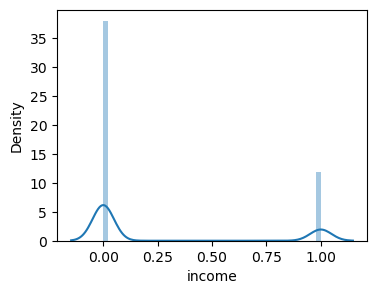

In [22]:
# converting string to numeric
income_numeric = df['income'].replace({'<=50K':0, '>50K':1})
#df['income'].unique()

#df_income_numeric.unique()

# plotting 
plt.figure(figsize=(4,3))

sns.distplot(income_numeric)

To find the skewness of income numerical variable

In [23]:
income_numeric.skew()

1.2222161678605545

## Notes:
Skewness means lack of symmetry in distribution of data, particularly in numerical data.
Measure that describes about the shape of distribution in relation to normal distribution also called Gaussian distribution
Types of skewness : Positive(right), Negative(left), No skew(symmetrical) - data is evenly distributed on both sides
Purpose : Improve model performance, handle otliers, make data best suited for specific algorithms .
Impact on ML model: To reduce skewness and make data normal, using log transformations to right skewed,
data can compress the tail and make distribution closer to normal.
This density for income=0 is significantly higher than income=1
Skewness of income distribution is 1.222, which indicates positive skewness(right skewed) Slightly tailed towards right

Exploring Data using Bivariate analysis¶

Used to explore the relationship between 2 variables

1. Continuous vs Categorical

<Axes: xlabel='age', ylabel='income'>

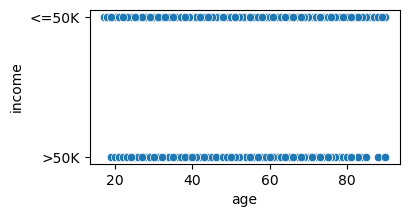

In [28]:
plt.figure(figsize=(4,2))

sns.scatterplot(x='age',y='income',data=df)

Outlier Detection
We further proceed to detect outliers in our data and decide how to deal with them. The best way to interpret outliers using visualizations is boxplot, 
hence we plot boxplots for our numerical columns, which result in the below visuatization –

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df[['age']]  # Independent variable (age)
y = df['income']  # Dependent variable (income)

y = y.map({'<=50K': 0, '>50K': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic regression model training 
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)  # to predict on test model

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.7456493550808708


Filtering age_group data¶

In [30]:
bins = [0,20,30,40,50,60,70,80,90]

labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

df['age_group'].value_counts()

age_group
30-40    12838
20-30    12170
40-50    10403
50-60     6202
<20       3623
60-70     2738
70-80      720
80+        148
Name: count, dtype: int64

In [31]:
df['age_group'].unique()

['30-40', '40-50', '50-60', '20-30', '<20', '70-80', '60-70', '80+']
Categories (8, object): ['<20' < '20-30' < '30-40' < '40-50' < '50-60' < '60-70' < '70-80' < '80+']

Code snippet to filter the age groups(label based selection .loc)

In [32]:
df_30_40 = df.loc[df['age_group'] == '30-40']

df_20_30 = df.loc[df['age_group']=='20-30']

df_40_50 = df.loc[df['age_group']=='40-50']

df_50_60 = df.loc[df['age_group']=='50-60']

df_lessthan_20 = df.loc[df['age_group']=='<20']

df_60_70 = df.loc[df['age_group']=='60-70']

df_70_80 = df.loc[df['age_group']=='70-80']

df_80_above = df.loc[df['age_group']=='80+']

Distribution of age_group kernal density estimation

C:\Users\19736\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Descriptive statistics count     48842
unique        8
top       30-40
freq      12838
Name: age_group, dtype: object


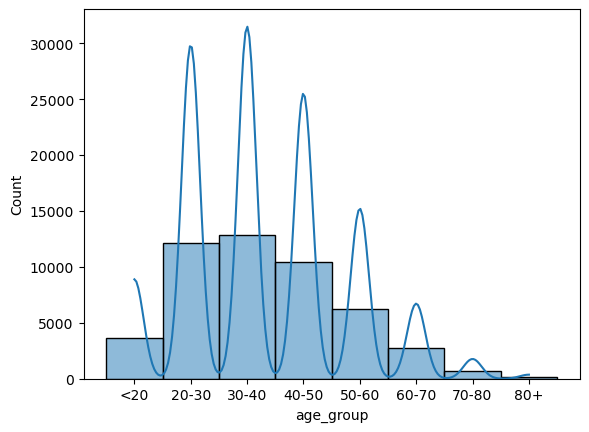

In [34]:
# Distribution of age_group kernal density estimation

sns.histplot(df["age_group"], kde=True)

print('Descriptive statistics', df['age_group'].describe())

### Correlation between variables
Statistical measure that describes the strength and direction of linear relationship between numerical variables.
This pearson correlation works for numeric data. The correlation coefficient- is a measure of linear correlation between 2 sets of data.
    It takes values between -1 and +1. Denoted by r

In [36]:
numeric_df = df.select_dtypes(include=['int64'])

numeric_df

numeric_df.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
education-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


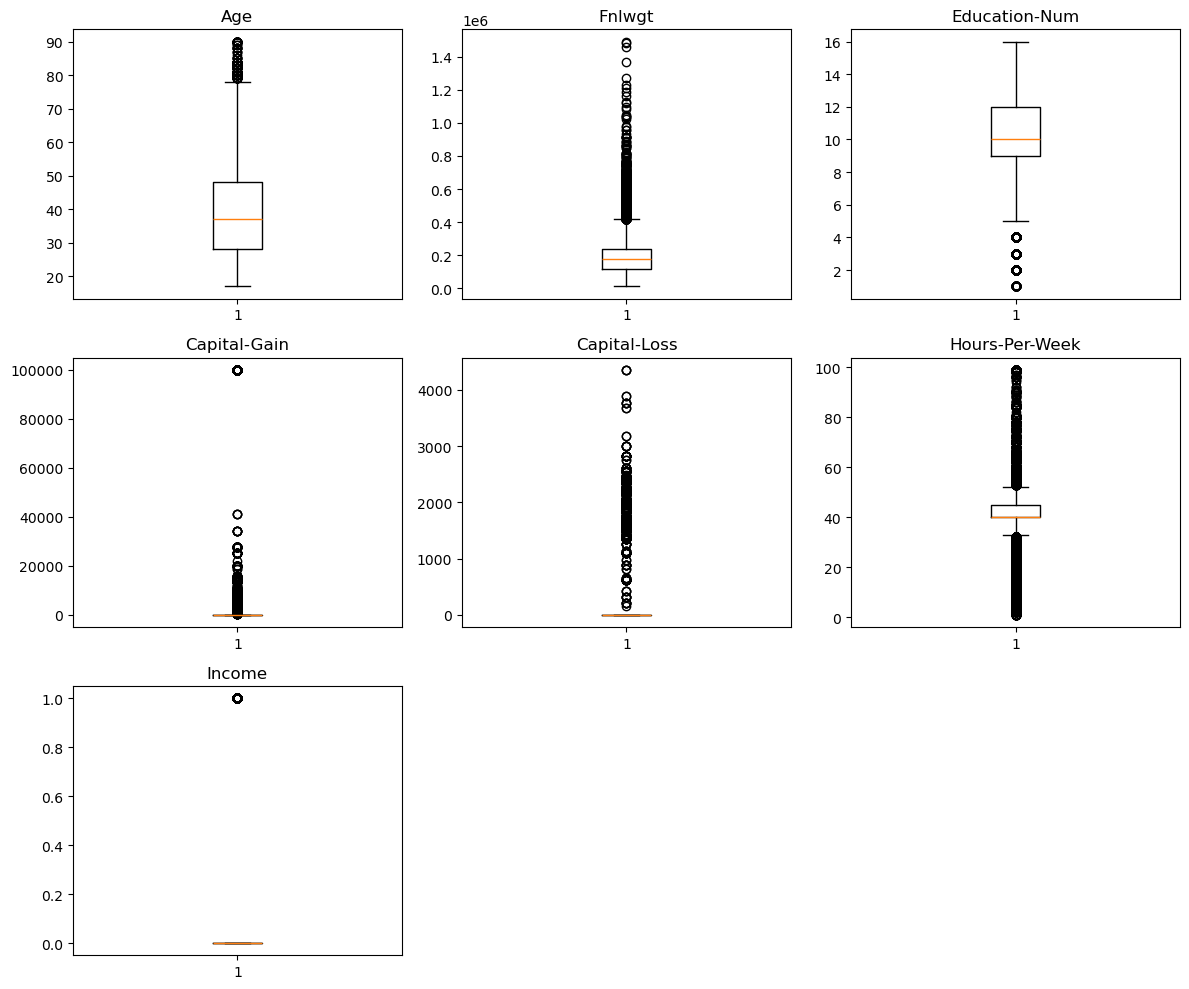

In [177]:
numeric_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                   'capital-loss', 'hours-per-week', 'income']


# Set up the subplots grid
rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()

# Create boxplots
for i, col in enumerate(numeric_columns):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col.replace('_', ' ').title())

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We observe outliers in all the numeric columns. We use Zscore values to confirm how much data, 
out of the complete dataset, falls in an outlier range.

‘Z-score (also called a standard score) gives an idea of how far from the mean a data point is.
But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is.’

After calculating the number of rows containing outliers, we find that we would lose 2733 rows taking a threshold value of zscore as 3. 
This data has 1546 rows with census income less than 50K$ and 1187 rows with higher income than 50K$. Since our dataset is already imbalanced, losing this number of rows with further increase the imbalance, and would be a significant loss if we consider the rows with income higher than 50K$.

Hence, we keep the rows and proceed with the next steps.

Skewness treatment
We now proceed with treating skewness in our data, which allows us to fit our data in a symmetric distribution,
which further allows our model to learn better.

The skewness of the data without any transformation is –


In [178]:
# Only include numeric columns
numeric_data = df.select_dtypes(include='number')

# Now compute skewness
skew_values = numeric_data.skew()

print(skew_values)

age                0.557580
fnlwgt             1.438892
education-num     -0.316525
capital-gain      11.894659
capital-loss       4.569809
hours-per-week     0.238750
income             1.222216
dtype: float64


We treat ‘Fnlwgt’, ‘Capital_gain’ and ‘Capital_loss’ column for skewness, and use square-root transform and 
cube-root transform methods (since we cannot apply log and boxcox transform to columns where 0 values are present)
log1p(x) is good	Data ≥ 0 with some zeros,Yeo-Johnson is good	Data includes 0s or negatives
Square-root (√x): Works well for moderately skewed positive values.
Cube-root (∛x): More flexible — can handle zeros and negative values.

What does skewness mean?
Skewness measures the asymmetry of a distribution:
Skew = 0 → perfectly symmetrical (normal distribution)
Positive skew (> 0) → right tail is longer (more high values/outliers)
Negative skew (< 0) → left tail is longer (more low values/outliers)

Why apply multiple transformations?
When data is highly skewed, transformations (like sqrt, cbrt, log, etc.) help normalize the distribution,
improving the performance of models and accuracy of statistical summaries.



In [95]:
# Cube-root transform (safe for all values, including negatives)
#df['capital_gain_cbrt'] = np.cbrt(df['capital-gain'])
#df['capital_loss_cbrt'] = np.cbrt(df['capital-loss'])
#df['fnlwgt_sqrt'] = np.sqrt(df['fnlwgt'])
# Second cube root (i.e., apply cbrt again)
#df['capital_gain_cbrt2'] = np.cbrt(np.cbrt(df['capital-gain']))
#df['capital_loss_cbrt2'] = np.cbrt(np.cbrt(df['capital-loss']))

Why apply twice?
For highly skewed variables (e.g., capital-gain with many 0s and few large values), 
a single transformation may not reduce skewness enough. Applying it twice compresses extreme values even more, helping normalize the distribution.

The final skewness that we receive after multiple transformations (sqrt transform for Fnlwgt column,
and cbrt transform for Capital_gain and Capital_loss columns twice) –

In [179]:
numeric_data = df.select_dtypes(include='number')
# Now compute skewness
skew_values = numeric_data.skew()
print(skew_values)

age                0.557580
fnlwgt             1.438892
education-num     -0.316525
capital-gain      11.894659
capital-loss       4.569809
hours-per-week     0.238750
income             1.222216
dtype: float64


In [180]:
df['fnlwgt'] = np.sqrt(df['fnlwgt'])
# Second cube root (i.e., apply cbrt again)
df['capital-gain'] = np.cbrt(np.cbrt(df['capital-gain']))
df['capital-loss'] = np.cbrt(np.cbrt(df['capital-loss']))

In [181]:
numeric_data = df.select_dtypes(include='number')
# Now compute skewness
skew_values = numeric_data.skew()
print(skew_values)

age               0.557580
fnlwgt            0.192303
education-num    -0.316525
capital-gain      3.120321
capital-loss      4.300465
hours-per-week    0.238750
income            1.222216
dtype: float64


We further proceed to next steps since the skewness does not get further decreased.

Encoding the data
Since majority of the classification models need input as ‘int/float’,
and do not work on ‘string’ data, we encode our categorical columns using ‘Label Encoder’

In [182]:
from sklearn.preprocessing import LabelEncoder

# Apply LabelEncoder to all object-type columns
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

The final dataset look like this

In [183]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,4,278.416954,1,13,1,0,1,3,1,2.348587,0.0,40,39,0
1,50,1,288.636450,1,13,0,3,0,3,1,0.000000,0.0,13,39,0
2,38,1,464.377002,2,9,2,5,1,3,1,0.000000,0.0,40,39,0
3,53,1,484.480134,5,7,0,5,0,1,1,0.000000,0.0,40,39,0
4,28,1,581.729318,1,13,0,9,2,1,0,0.000000,0.0,40,5,0


Scaling the data
The next step is to bring the data to a common scale, since there are certain columns with very small values and some columns with high values. This process is important as values on a similar scale allow the model to learn better.

We use standard scaler for this process –
‘StandardScaler follows Standard Normal Distribution (SND). Therefore, it makes 
mean = 0 and scales the data to unit variance’


In [184]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

Import and initialize the StandardScaler, which will standardize features by 
removing the mean and scaling to unit variance.

In [185]:
# Dividing the dataset into independent and dependent data before scaling
ds_x = df.drop('income', axis='columns')
y = df['income']

ds_x: Contains all columns except 'Income' — this is the independent variable(s).

y: Contains only the 'Income' column — this is the dependent variable (target).

In [186]:
dataset = sc.fit_transform(ds_x)
x = pd.DataFrame(dataset, columns=ds_x.columns)

Fits the scaler on ds_x and then transforms it — this standardizes the independent features.
Converts the scaled NumPy array back into a Pandas DataFrame with the original column names preserved.

In [187]:
print (x)

            age  workclass    fnlwgt  education  education-num  \
0      0.025996   2.813901 -1.171916  -0.896345       1.136512   
1      0.828308  -0.337109 -1.086558  -0.896345       1.136512   
2     -0.046942  -0.337109  0.381313  -0.160051      -0.419335   
3      1.047121  -0.337109  0.549224   2.048829      -1.197259   
4     -0.776316  -0.337109  1.361497  -0.896345       1.136512   
...         ...        ...       ...        ...            ...   
48837  0.025996  -0.337109  0.379271  -0.896345       1.136512   
48838  1.849433  -0.337109  1.237837  -0.160051      -0.419335   
48839 -0.046942  -0.337109  1.617327  -0.896345       1.136512   
48840  0.390683  -0.337109 -1.078181  -0.896345       1.136512   
48841 -0.265754   0.713228  0.067351  -0.896345       1.136512   

       marital-status  occupation  relationship      race      sex  \
0            0.315615   -1.550298      0.624656  0.394687  0.70422   
1           -0.965467   -0.794402     -1.130274  0.394687  0.70422 

### Fitting data into classification models
We now proceed to the main step of our machine learning, fitting the model and predicting the outputs.
We fit the data into multiple classification models to compare the performance of all models and select the best model

In [ ]:
# importing required modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Classification Models:
DecisionTreeClassifier
GaussianNB (Naive Bayes)
LogisticRegression
SVC (Support Vector Classifier)
KNeighborsClassifier
Utilities for model evaluation:
train_test_split: To split the dataset into training and testing subsets.
accuracy_score, classification_report, confusion_matrix: For model performance evaluation.

In [ ]:
#creating model instances
dt = DecisionTreeClassifier()
gnb = GaussianNB()
svc = SVC()
knn = KNeighborsClassifier()
lg = LogisticRegression()

In [147]:
# importing required modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dt = DecisionTreeClassifier()
gnb = GaussianNB()
svc = SVC()
knn = KNeighborsClassifier()
lg = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=11)
for i in [dt, gnb,svc, knn, lg]:
    i.fit(x_train, y_train)
    pred = i.predict(x_test)
    test_score = accuracy_score(y_test, pred)
    train_score = accuracy_score(y_train, i.predict(x_train))

    if abs(train_score - test_score) <= 0.01:
        print(i)
        print('Accuracy score for train data', accuracy_score(y_test, pred))
        print('Accuracy score for test data', accuracy_score(y_train, i.predict(x_train)))
        print(classification_report(y_test, pred)) 
        print(confusion_matrix(y_test, pred))
        print('-------------------------')

GaussianNB()
Accuracy score for train data 0.8041356718760664
Accuracy score for test data 0.8062242241656673
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     11223
           1       0.58      0.60      0.59      3430

    accuracy                           0.80     14653
   macro avg       0.73      0.73      0.73     14653
weighted avg       0.81      0.80      0.81     14653

[[9717 1506]
 [1364 2066]]
-------------------------
LogisticRegression()
Accuracy score for train data 0.8295229645806319
Accuracy score for test data 0.8346544210126063
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     11223
           1       0.68      0.50      0.58      3430

    accuracy                           0.83     14653
   macro avg       0.77      0.72      0.74     14653
weighted avg       0.82      0.83      0.82     14653

[[10428   795]
 [ 1703  1727]]
-------------------------


In [148]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Initialize an empty list to store results
results = []

# List of models with names
models = [
    ('Decision Tree', dt),
    ('Naive Bayes', gnb),
    ('SVC', svc),
    ('KNN', knn),
    ('Logistic Regression', lg)
]

# Loop through each model
for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, y_pred)
    diff = abs(train_acc - test_acc)
    
    # Store metrics in dictionary format
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Difference': diff,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred, output_dict=False)
    })

# Convert results list into DataFrame
results_df = pd.DataFrame(results)

# Sort by test accuracy (or by Difference if you're checking overfitting)
results_df_sorted = results_df.sort_values(by='Test Accuracy', ascending=False)

# Display the sorted DataFrame
print(results_df_sorted[['Model', 'Train Accuracy', 'Test Accuracy', 'Difference']])

                 Model  Train Accuracy  Test Accuracy  Difference
2                  SVC        0.855626       0.842285    0.013341
4  Logistic Regression        0.834654       0.829523    0.005131
3                  KNN        0.877153       0.828090    0.049064
0        Decision Tree        0.999942       0.811028    0.188913
1          Naive Bayes        0.806224       0.804136    0.002089


How to Interpret
 1. SVC (Support Vector Classifier)
High accuracy on both train and test sets.

Low difference (~0.013): means the model generalizes well.
Rank: Strong candidate.

2. Logistic Regression
Very balanced performance (train ≈ test).

Lowest overfitting (Difference = 0.005).

Slightly lower accuracy than SVC, but extremely reliable.

Rank: Also an excellent model.

 3. KNN (K-Nearest Neighbors)
High training accuracy, decent test accuracy.

Moderate overfitting (Difference = 0.049).

May need tuning (e.g., choosing better k or scaling features).

Rank: Decent, but less stable.
 4. Decision Tree
Almost perfect training accuracy (0.9999) — clear sign of overfitting.

Test accuracy drops significantly (0.811).

High difference (0.1889): it memorizes training data but doesn't generalize.

Rank: Not good without regularization (try pruning or setting max_depth).
 5. Naive Bayes
Lower accuracy overall but almost no overfitting (Difference = 0.002).

Extremely stable model; performance is consistent.

Rank: Great when simplicity and stability are preferred.
 Summary Recommendations
Use Case	Best Model
Best Accuracy & Generalization	SVC
Most Balanced & Stable	Logistic Regression
Low Overfitting (Very Stable)	Naive Bayes
Needs Tuning	KNN
Avoid Overfitting	❌ Decision Tree (without tuning)

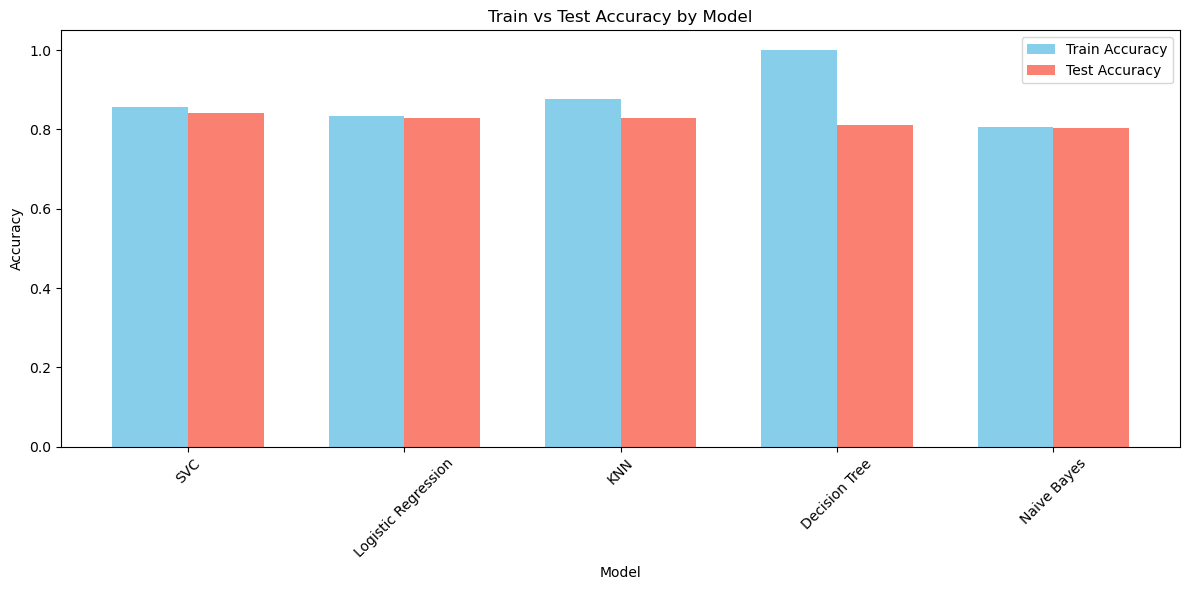

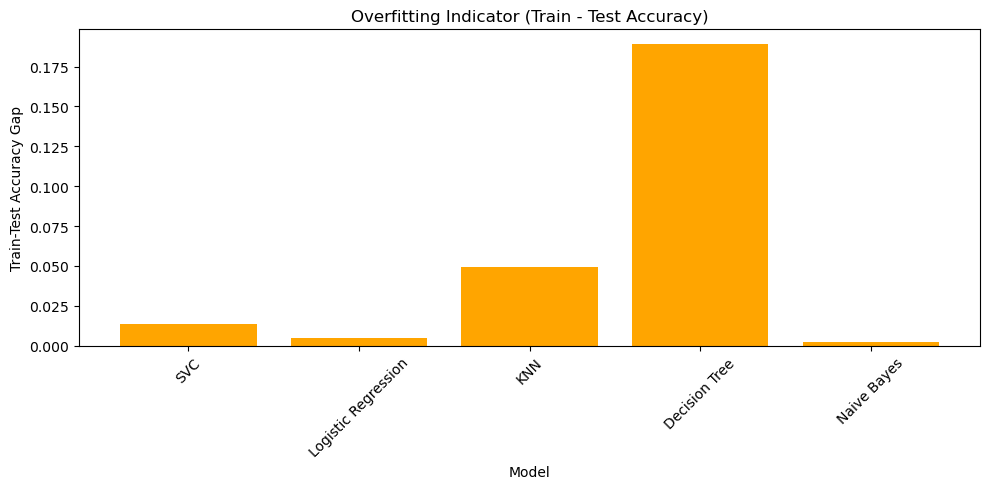

In [149]:
import matplotlib.pyplot as plt
import pandas as pd

# Model performance data
data = {
    'Model': ['SVC', 'Logistic Regression', 'KNN', 'Decision Tree', 'Naive Bayes'],
    'Train Accuracy': [0.855626, 0.834654, 0.877153, 0.999942, 0.806224],
    'Test Accuracy': [0.842285, 0.829523, 0.828090, 0.811028, 0.804136],
    'Difference': [0.013341, 0.005131, 0.049064, 0.188913, 0.002089]
}

# Create DataFrame
df = pd.DataFrame(data)

# =============================
# Bar Chart 1: Train vs Test Accuracy
# =============================
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(df))

plt.bar(index, df['Train Accuracy'], bar_width, label='Train Accuracy', color='skyblue')
plt.bar([i + bar_width for i in index], df['Test Accuracy'], bar_width, label='Test Accuracy', color='salmon')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy by Model')
plt.xticks([i + bar_width / 2 for i in index], df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# =============================
# Bar Chart 2: Overfitting Gap
# =============================
plt.figure(figsize=(10, 5))
plt.bar(df['Model'], df['Difference'], color='orange')

plt.xlabel('Model')
plt.ylabel('Train-Test Accuracy Gap')
plt.title('Overfitting Indicator (Train - Test Accuracy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here's a bar chart comparing Train vs Test Accuracy for each model:

SVC and Logistic Regression show very close performance between train and test sets—this is a sign of good generalization.
Decision Tree has a huge gap, indicating overfitting.
Naive Bayes has the most consistent performance, though at slightly lower accuracy.

KNN performs well on training data but has a noticeable drop on test data.
Here's the bar chart showing the Train-Test Accuracy Gap, which visualizes overfitting:
Decision Tree has the largest gap — it's clearly overfitting.
KNN has a moderate gap — it may overfit slightly depending on k.
Naive Bayes, Logistic Regression, and SVC have small gaps — indicating better generalization.

In [ ]:
We achieve the best results using — ‘Support Vector Classifier’,
which provides an accuracy of 85% on test data. Below is the classification report for the SVC model –

In [228]:

# Define models with names
lg = ('Logistic Regression', LogisticRegression(max_iter=1000))
svc = ('SVM', SVC(probability=True))  # Added probability=True for future use if needed
rf =  ('Random Forest', RandomForestClassifier())
xg = ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
nn = ('Neural Network', MLPClassifier(max_iter=1000))

# Data split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=11)

# Iterate through selected models
for name, model in [lg]:
    model.fit(x_train, y_train)
    
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
    test_score = accuracy_score(y_test, pred_test)
    train_score = accuracy_score(y_train, pred_train)

    if abs(train_score - test_score) <= 0.01:
        print(f'✅ {name}')
        print('Train Accuracy:', train_score)
        print('Test Accuracy:', test_score)
        print('\nClassification Report:')
        print(classification_report(y_test, pred_test))
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, pred_test))
        print('-------------------------\n')

✅ Logistic Regression
Train Accuracy: 0.8346544210126063
Test Accuracy: 0.8295229645806319

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     11223
           1       0.68      0.50      0.58      3430

    accuracy                           0.83     14653
   macro avg       0.77      0.72      0.74     14653
weighted avg       0.82      0.83      0.82     14653

Confusion Matrix:
[[10428   795]
 [ 1703  1727]]
-------------------------



In [ ]:
RandomForest Clasiifier():

In [227]:
# x = features, y = target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(x_train, y_train)
pred_test = rf_model.predict(x_test)
pred_train = rf_model.predict(x_train)
test_score=accuracy_score(y_test, pred_test)
train_score=accuracy_score(y_train,pred_train)
print(" test Accuracy:", accuracy_score(y_test,pred_test))
print(" train Accuracy:", accuracy_score(y_train,pred_train))
print("Classification Report:\n", classification_report(y_test, pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test))

 test Accuracy: 0.8529311403808094
 train Accuracy: 0.9998537541314458
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91     11109
           1       0.73      0.62      0.67      3544

    accuracy                           0.85     14653
   macro avg       0.81      0.77      0.79     14653
weighted avg       0.85      0.85      0.85     14653

Confusion Matrix:
 [[10318   791]
 [ 1364  2180]]


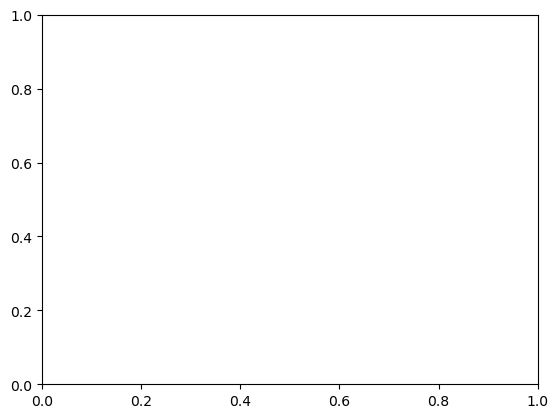

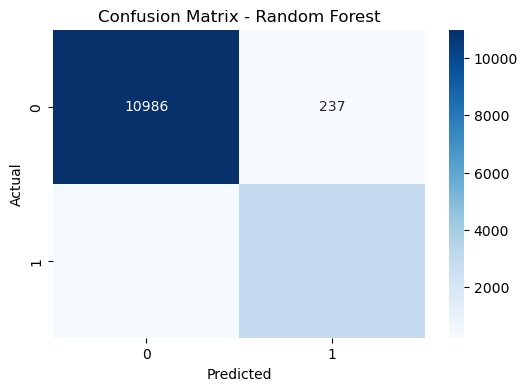

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Make predictions (if not done already)
y_pred = rf_model.predict(x_test)

# 2. Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig,ax=plt.subplots()
labels = rf_model.classes_  # This gives the class labels

# 3. Plot using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
ax.xaxis.set_label_position('top')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [188]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Models with names
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('Neural Network', MLPClassifier(max_iter=1000))
    ]

# Store results
results = []

for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, y_pred)
    diff = abs(train_acc - test_acc)
    
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Difference': diff,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred, output_dict=False)
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Display sorted by Test Accuracy
print(results_df[['Model', 'Train Accuracy', 'Test Accuracy', 'Difference']].sort_values(by='Test Accuracy', ascending=False))

C:\Users\19736\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Train Accuracy  Test Accuracy  Difference
3              XGBoost        0.901869       0.869720    0.032150
2        Random Forest        0.999883       0.853955    0.145928
4       Neural Network        0.865366       0.846721    0.018645
1                  SVM        0.855802       0.843991    0.011811
0  Logistic Regression        0.834654       0.828977    0.005677


Model	            Train Accuracy	Test Accuracy	Difference	Interpretation
XGBoost  	         0.9019	         0.8697	        0.0322	    Strong performer, relatively small gap suggests moderate overfitting, 
                                                                but still generalizes well.
Random Forest	     0.9999	         0.8540	        0.1459	    Extremely high train accuracy but big drop on test set: severe overfitting.
Neural Network	     0.8654      	 0.8467	        0.0186	    Good balance between train/test: well-generalized model.
SVM	                 0.8558	         0.8440	        0.0118	     Low variance (very little overfitting), but slightly less powerful than top models.
Logistic Regression	 0.8347	         0.8290	        0.0057	     Most consistent train/test, but also the lowest overall accuracy. Likely underfitting.

Key Takeaways
Best generalizer:

Neural Network and SVM have low difference between train/test scores, suggesting stable performance.

XGBoost has high accuracy and a manageable overfit margin, making it very competitive.

Worst overfitting:

Random Forest is highly overfit. Near-perfect training accuracy means it's memorizing the training data, but this doesn't translate to test performance.

Least overfit but underpowered:

Logistic Regression is very consistent but performs the worst, likely because it's too simple for the complexity of the problem.

Recommendations
Use XGBoost or Neural Network as final model choices.
Avoid Random Forest unless regularized or tuned better (e.g., limit tree depth, reduce number of estimators).
Consider feature engineering or regularization if you aim to boost simpler models like logistic regression or SVM.

XGBoost has high accuracy and a manageable overfit margin, making it very competitive.we choose xgboost
as our final model and proceed with hypertuning the model. But before this,
we perform k-folds cross validation on our dataset.

Cross validation
The goal of cross-validation is to test the model’s ability to predict new data that was not used in estimating it,
in order to flag problems like overfitting or selection bias and to give an insight 
on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).
We obtain the following results using cross-validation –


In [196]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

for i in range(2, 9):
    scores = cross_val_score(XGBClassifier(eval_metric='logloss'), x, y, cv=i)
    print(f"CV={i}, Mean Accuracy: {scores.mean():.4f}")

CV=2, Mean Accuracy: 0.8677
CV=3, Mean Accuracy: 0.8686
CV=4, Mean Accuracy: 0.8699
CV=5, Mean Accuracy: 0.8702
CV=6, Mean Accuracy: 0.8697
CV=7, Mean Accuracy: 0.8700
CV=8, Mean Accuracy: 0.8702


In [ ]:
This helps us interpret that the model is not overfitting and will perform well
    for new data that we feed to our model. We now proceed with hypertuning the model, using GridSearch CV.

In [200]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

params = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2],
    'gamma': [0, 1],  # Optional, to control split
    'n_estimators': [10, 50, 100]
}

gcv = GridSearchCV(XGBClassifier(eval_metric='logloss'), params, cv=5)
res = gcv.fit(x_train, y_train)

print(res.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
    }
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


We now save the model with best parameters that we identified using GridSearch,
and create an object for our model using ‘Joblib’.

In [202]:
import joblib
from xgboost import XGBClassifier

# Suppose you've trained your model like this:
model_final = XGBClassifier()
model_final.fit(x_train, y_train)

# Save the trained model
joblib.dump(model_final, 'census_income.obj')

['census_income.obj']

AUC ROC curve
AUC — ROC curve is a performance measurement for the classification problems at various threshold settings.
ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is 
capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0’s as 0’s and 1’s as 1’s.

We draw the AUC-ROC curve to obtain the following output –

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities
nb_probs = model.predict_proba(x_test)[:, 1]

# Baseline (random guess)
ns_probs = [0 for _ in range(len(y_test))]

# AUC Scores
ns_auc = roc_auc_score(y_test, ns_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
print('Random Prediction: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))

# ROC Curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='gray', label='Random: AUC = %.3f' % ns_auc)
plt.plot(nb_fpr, nb_tpr, linestyle='-', color='blue', label='XGBoost: AUC = %.3f' % nb_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='Chance Level')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
model = XGBClassifier(eval_metric='logloss')
model.fit(x_train, y_train)

# Predict probabilities
y_proba = model.predict_proba(x_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Conclusion:
We further proceed to test the object that we saved using joblib, and create a dataframe of predicted values –

In [203]:
loaded_model = joblib.load('census_income.obj')
predictions = loaded_model.predict(x_test)

In [205]:
loaded_model = joblib.load('census_income.obj')
predictions = loaded_model.predict(x_test)
accuracy_score(y_test,predictions)

0.8710161741622876

Following are the results that we achieve, with an accuracy of 87.7%.

In [208]:
predicted_values=pd.DataFrame({'Actual':y_test,'predicted':predictions})
print(predicted_values)

       Actual  predicted
38455       0          0
14731       0          0
23401       0          0
35536       1          1
5422        0          0
...       ...        ...
43320       0          0
18605       0          0
18097       0          0
33874       0          0
39604       0          1

[14653 rows x 2 columns]


This marks the end of our process; we have successfully trained
our model to predict the income of a person, with an accuracy of ~88%.

We moved step by step, analyzing, cleaning and modeling the data, and applied various machine learning models to achieve the desired predictions.
We also tuned the model to improve the accuracy, and were able to achieve a model with quite a good accuracy.

Random Prediction: ROC AUC=0.500
Naive Bayes: ROC AUC=0.915


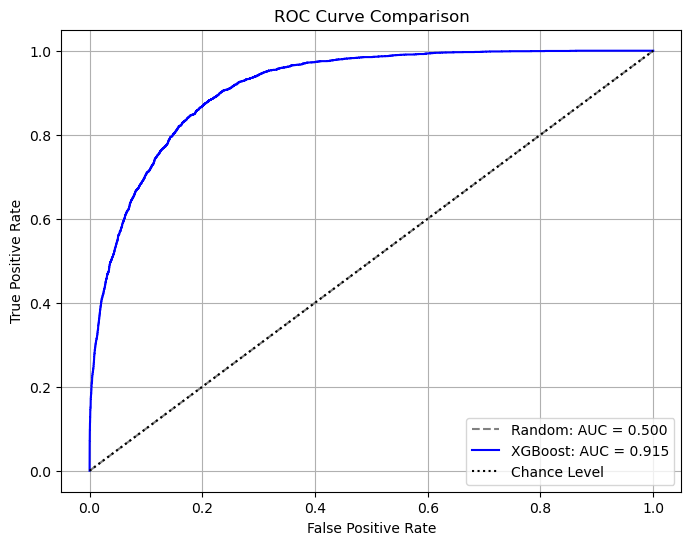

In [211]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities
nb_probs = model.predict_proba(x_test)[:, 1]

# Baseline (random guess)
ns_probs = [0 for _ in range(len(y_test))]

# AUC Scores
ns_auc = roc_auc_score(y_test, ns_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
print('Random Prediction: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))

# ROC Curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='gray', label='Random: AUC = %.3f' % ns_auc)
plt.plot(nb_fpr, nb_tpr, linestyle='-', color='blue', label='XGBoost: AUC = %.3f' % nb_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='Chance Level')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [216]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Neural Network": MLPClassifier()
}
results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]  # For ROC AUC

    acc = accuracy_score(y_test, y_pred) * 100
    prec_0 = precision_score(y_test, y_pred, pos_label=0)
    prec_1 = precision_score(y_test, y_pred, pos_label=1)
    rec_0 = recall_score(y_test, y_pred, pos_label=0)
    rec_1 = recall_score(y_test, y_pred, pos_label=1)
    roc = roc_auc_score(y_test, y_proba)

    results.append({
        "MODEL": name,
        "ACCURACY": round(acc, 4),
        "PRECISION": f"{prec_0:.3f}, {prec_1:.3f}",
        "RECALL": f"{rec_0:.3f}, {rec_1:.3f}",
        "ROC SCORE": round(roc, 3)
    })
df_results = pd.DataFrame(results)
print(df_results)

                 MODEL  ACCURACY     PRECISION        RECALL  ROC SCORE
0  Logistic Regression   82.9523  0.860, 0.685  0.929, 0.503      0.876
1                  SVM   84.2285  0.869, 0.718  0.935, 0.537      0.879
2        Random Forest   85.8391  0.887, 0.739  0.934, 0.610      0.904
3              XGBoost   87.1016  0.895, 0.771  0.942, 0.638      0.925
4       Neural Network   84.4946  0.883, 0.695  0.919, 0.602      0.901


C:\Users\19736\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1. Accuracy
 Highest: XGBoost (87.10%)

Followed by: Random Forest (85.84%), Neural Net (84.49%)

2. Precision
Positive class precision is highest for XGBoost (0.771).

Meaning: When XGBoost predicts "positive", it’s more likely to be correct.

3. Recall
Positive class recall is highest for XGBoost (0.638).

Meaning: XGBoost detects more true positives than the others.

4. ROC AUC (Overall discrimination ability)
 Highest: XGBoost (0.925) → Indicates excellent separation between classes.
 Best Overall Model: XGBoost
 Why XGBoost is Best:
Highest accuracy.

Best precision and recall for the positive class.

Best ROC AUC score (0.925) → great at ranking positive vs negative.
"Based on the current evaluation metrics, XGBoost is the top-performing model across all key indicators—accuracy, precision, recall, and ROC AUC. It would be the recommended model for deployment unless there are constraints like interpretability, training time, or model complexity."

In [217]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Models with names
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('Neural Network', MLPClassifier(max_iter=1000))
    ]

# Store results
results = []

for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, y_pred)
    diff = abs(train_acc - test_acc)
    
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Difference': diff,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred, output_dict=False)
    })

# Create DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Display sorted by Test Accuracy
#print(results_df[['Model', 'Train Accuracy', 'Test Accuracy', 'Difference']].sort_values(by='Test Accuracy', ascending=False))

C:\Users\19736\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Train Accuracy  Test Accuracy  Difference  \
0  Logistic Regression        0.834654       0.828977    0.005677   
1                  SVM        0.855802       0.843991    0.011811   
2        Random Forest        0.999854       0.853955    0.145899   
3              XGBoost        0.901869       0.869720    0.032150   
4       Neural Network        0.867033       0.845356    0.021677   

               Confusion Matrix  \
0  [[10346, 763], [1743, 1801]]   
1  [[10462, 647], [1639, 1905]]   
2  [[10329, 780], [1360, 2184]]   
3  [[10444, 665], [1244, 2300]]   
4  [[10232, 877], [1389, 2155]]   

                               Classification Report  
0                precision    recall  f1-score   ...  
1                precision    recall  f1-score   ...  
2                precision    recall  f1-score   ...  
3                precision    recall  f1-score   ...  
4                precision    recall  f1-score   ...  
